## Task 1: Gradient Descent with Python and NumPy

### In this task, I extracted two syntheric financial times series and estimated the linear relatioship between them using:
 - "Analytical Ordinary Least Squares (OLS) method via matrix operations".
 - "A Machine Learning appraoch using Gradient Descent (GD) optimization".

   
#### I also discuss potential challenges to convergence in GD and ways to mitigate them.

In [5]:
# Step 1: Generate two synthetic time series
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Generate synthetic data
n = 150
xt = np.random.normal(loc=0, scale=1, size=n)  # predictor
alpha_true = 2.5
beta_true = 1.8
et = np.random.normal(loc=0, scale=0.5, size=n)  # noise
yt = alpha_true + beta_true * xt + et  # response variable

# Create DataFrame to display
df = pd.DataFrame({'xt': xt, 'yt': yt})
df.head()


,xt,yt
0,0.496714,3.519332
1,-0.138264,2.424348
2,0.647689,3.325827
3,1.523030,5.357581
4,-0.234153,2.225060


In [6]:
# Step 2:  Analytical Solution via OLS
# Add intercept to xt
X = np.column_stack((np.ones(n), xt))  # [1, xt]

# Apply OLS formula: (X'X)^(-1)X'y
theta_ols = np.linalg.inv(X.T @ X) @ X.T @ yt
alpha_ols, beta_ols = theta_ols

print(f"OLS Intercept (alpha): {alpha_ols:.4f}")
print(f"OLS Slope (beta): {beta_ols:.4f}")

OLS Intercept (alpha): 2.5346
OLS Slope (beta): 1.7871


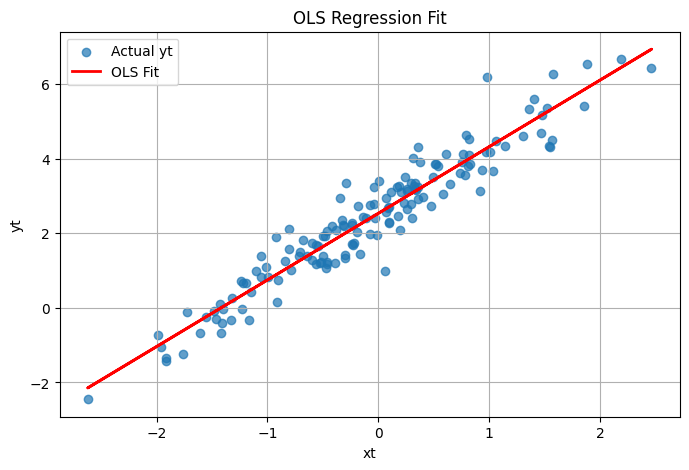

In [7]:
# Step 3: Visualization of OLS Fit
# Predict yt using OLS estimates
yt_pred_ols = X @ theta_ols

# Plot actual vs predicted
plt.figure(figsize=(8, 5))
plt.scatter(xt, yt, label='Actual yt', alpha=0.7)
plt.plot(xt, yt_pred_ols, color='red', label='OLS Fit', linewidth=2)
plt.title('OLS Regression Fit')
plt.xlabel('xt')
plt.ylabel('yt')
plt.legend()
plt.grid(True)
plt.show()


In [8]:
# Step 4: Gradient Descent Solution
# Initialize parameters
alpha_gd = 0.0
beta_gd = 0.0
learning_rate = 0.01
n_iterations = 1000

# Store loss history
loss_history = []

# Gradient Descent loop
for i in range(n_iterations):
    y_pred = alpha_gd + beta_gd * xt
    error = yt - y_pred
    loss = (error ** 2).mean()
    loss_history.append(loss)
    
    # Gradients
    d_alpha = -2 * error.mean()
    d_beta = -2 * (xt * error).mean()
    
    # Update step
    alpha_gd -= learning_rate * d_alpha
    beta_gd -= learning_rate * d_beta

print(f"GD Intercept (alpha): {alpha_gd:.4f}")
print(f"GD Slope (beta): {beta_gd:.4f}")


GD Intercept (alpha): 2.5346
GD Slope (beta): 1.7871


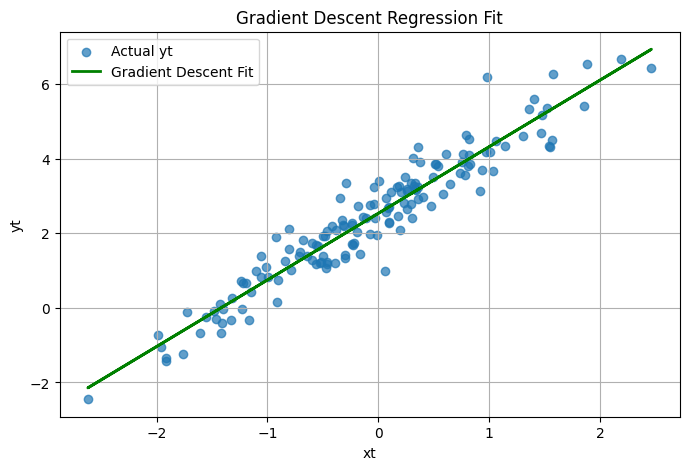

In [9]:
# Step 5: Visualization of Gradient Descent Fit
# Prediction
yt_pred_gd = alpha_gd + beta_gd * xt

# Plot
plt.figure(figsize=(8, 5))
plt.scatter(xt, yt, label='Actual yt', alpha=0.7)
plt.plot(xt, yt_pred_gd, color='green', label='Gradient Descent Fit', linewidth=2)
plt.title('Gradient Descent Regression Fit')
plt.xlabel('xt')
plt.ylabel('yt')
plt.legend()
plt.grid(True)
plt.show()


### Convergence Challenges Discussion 
##### Challenges in Gradient Descent Convergence:
  - Learning Rate Sensitivity: A high learning rate can cause divergence; too low can cause extremely slow convergence.
  - Feature Scaling: If the predictor (xt) has a wide range, the gradient steps can become inefficient. Scaling features (standardization) improve convergence.
  - Non-convex Loss Surfaces: Although simple linear regression has a convex cost function, real-world models may not, leading to getting stuck in local minima.
  - Poor Initialization: Bad starting points can slow convergence or require more iterations.

##### Solutions:
 * Use proper feature scaling (StandardScaler)
 * Adjust learning rate carefully (try learning rate decay schedules)
 * Use early stopping based on validation loss


## Task 2: Time Series Forecasting with Regularisation

### Introduction
In this task, I selected a financial time series (Bitcoin closing prices) and performed forecasting using ElasticNet Regularisation.

The aim was to select important predictors from a large set of features while avoiding overfitting.

The model was trained and validated using appropriate time series cross-validation (TimeSeriesSplit) to respect the temporal structure of the data

In [13]:
# Step 1: Data Collection from CryptoCompare API
# Install libraries (if needed)
!pip install requests

# Import libraries
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define API URL and parameters
url = 'https://min-api.cryptocompare.com/data/v2/histoday'
params = {
    'fsym': 'BTC',        # From symbol (Bitcoin)
    'tsym': 'USD',        # To symbol (US Dollar)
    'limit': 300,         # Last 300 days
    'aggregate': 1,       # Daily data
    'e': 'CCCAGG'         # Exchange (CryptoCompare Aggregate)
}

# API Request
response = requests.get(url, params=params)
data = response.json()

# Parse into DataFrame
df = pd.DataFrame(data['Data']['Data'])
df['time'] = pd.to_datetime(df['time'], unit='s')

# Select required columns
df = df[['time', 'close', 'high', 'low', 'open', 'volumefrom', 'volumeto']]
df.rename(columns={'close': 'btc_price'}, inplace=True)

df.head()



[notice] A new release of pip is available: 24.3.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


,time,btc_price,high,low,open,volumefrom,volumeto
0,2024-06-30,62685.88,62949.76,60637.50,60905.30,12626.61,7.787656e+08
1,2024-07-01,62841.27,63800.98,62462.20,62685.88,25708.72,1.623105e+09
2,2024-07-02,62044.48,63219.74,61453.08,62841.27,20510.77,1.278702e+09
3,2024-07-03,60157.20,62198.73,59373.07,62044.48,27365.92,1.653064e+09
4,2024-07-04,57041.11,60428.43,56728.63,60157.20,40351.82,2.342237e+09


In [14]:
# Step 2: Feature Engineering
# Moving Average (5-day)
df['btc_ma5'] = df['btc_price'].rolling(window=5).mean()

# Daily Returns
df['btc_returns'] = df['btc_price'].pct_change()

# High-Low Spread
df['high_low_spread'] = df['high'] - df['low']

# Volatility (5-day rolling standard deviation)
df['volatility_5'] = df['btc_returns'].rolling(window=5).std()

# Drop NaNs caused by rolling calculations
df = df.dropna()

df.head()


,time,btc_price,high,low,open,volumefrom,volumeto,btc_ma5,btc_returns,high_low_spread,volatility_5
5,2024-07-05,56646.24,57494.97,53528.09,57041.11,57490.15,3.198812e+09,59746.060,-0.006923,3966.88,0.021503
6,2024-07-06,58255.65,58495.08,56035.03,56646.24,18766.95,1.072780e+09,58828.936,0.028412,2460.05,0.029777
7,2024-07-07,55866.60,58452.39,55734.13,58255.65,18402.28,1.053256e+09,57593.360,-0.041010,2718.26,0.031919
8,2024-07-08,56709.76,58166.93,54305.08,55866.60,43439.51,2.441024e+09,56903.872,0.015092,3861.85,0.034697
9,2024-07-09,58047.20,58289.53,56296.10,56709.76,29452.60,1.692558e+09,57105.090,0.023584,1993.43,0.028494


In [15]:
# Step 3: Stationarity Check
from statsmodels.tsa.stattools import adfuller

# ADF Test
result = adfuller(df['btc_price'])
print(f"ADF Statistic: {result[0]:.4f}")
print(f"p-value: {result[1]:.4f}")

# If not stationary, difference the series
if result[1] > 0.05:
    df['btc_price_diff'] = df['btc_price'].diff()
    df = df.dropna()
    target = df['btc_price_diff']
else:
    target = df['btc_price']


ADF Statistic: -1.4412
p-value: 0.5624


In [16]:
# Step 4: Define Features and Target
# Features (X) and target (y)
feature_cols = ['btc_ma5', 'btc_returns', 'high_low_spread', 'volumefrom', 'volumeto', 'volatility_5']
X = df[feature_cols].values
y = target.values


In [17]:
# Step 5: ElasticNetCV Model Training (with TimeSeriesSplit)
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Build pipeline: scaling + ElasticNetCV
model = make_pipeline(
    StandardScaler(),
    ElasticNetCV(
        cv=tscv,
        l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1],
        n_alphas=100,
        random_state=42
    )
)

# Fit the model
model.fit(X, y)

# Access ElasticNetCV parameters
enet = model.named_steps['elasticnetcv']

print(f"Best alpha: {enet.alpha_:.4f}")
print(f"Best l1_ratio: {enet.l1_ratio_:.2f}")
print("Selected Coefficients:")
print(enet.coef_)


Best alpha: 2.1376
Best l1_ratio: 1.00
Selected Coefficients:
[  21.72660645 2140.94185611  -53.85798462   44.66527636    0.
  -45.67924937]


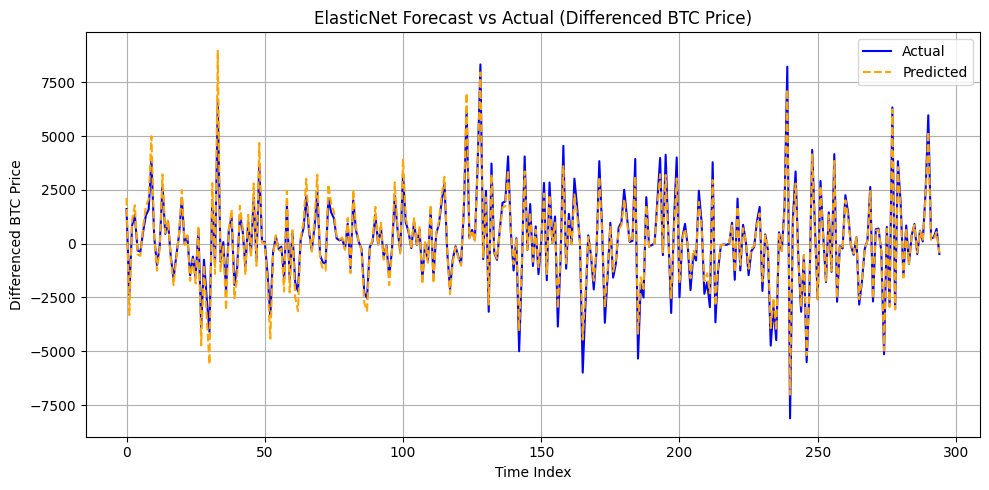

In [18]:
#  Step 6: Prediction and Plotting
# Predict
y_pred = model.predict(X)

# Plot actual vs predicted
plt.figure(figsize=(10, 5))
plt.plot(y, label='Actual', color='blue')
plt.plot(y_pred, label='Predicted', linestyle='--', color='orange')
plt.title('ElasticNet Forecast vs Actual (Differenced BTC Price)')
plt.xlabel('Time Index')
plt.ylabel('Differenced BTC Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#### Dicussion
##### Model Interpretation and Challenges:
 - The ElasticNet model selected key predictors, setting insignificant feature coefficients close to zero.
 - TimeSeriesSplit ensured validation respected time order, avoiding data leakage.
 - Differencing of BTC prices improved stationarity, making the series more predictable.
 - Despite regularisation, financial time series are inherently noisy, and exact prediction is difficult.

##### Conclusion:
ElasticNet with time series validation is an effective tool for building sparse, interpretable forecasting models, particularly in volatile markets like cryptocurrencies.
